# [Dataset](https://zenodo.org/records/5516552)

Data included in these two datasets are 10-minute data generated from six wind turbines and three met masts and are arranged in six files, each of which is associated with a turbine. The six turbines are named WT1 through WT6, respectively.  The layout of the turbines and the met masts is shown in Fig. 5.6 of the Data Science for Wind Energy book. On the offshore wind farm, all seven environmental variables as mentioned above are available, namely x =(V, D, rho, H, I, Sa, Sb), whereas on the inland wind farm, the humidity measurements are not available, nor is the above-hub wind shear, meaning that x =(V, D, rho, I, Sb). Variables in x were measured by sensors on the met mast, whereas y was measured at the wind turbines. Each met mast has two wind turbines associated with it, meaning that the x's measured at a met mast are paired with the y's of two associated turbines. For WT1 and WT2, the data were collected from July 30, 2010 through July 31, 2011 and for WT3 and WT4, the data were collected from April 29, 2010 through April 30, 2011. For WT5 and WT6, the data were collected from January 1, 2009 through December 31, 2009.

Meaning of variables; 
- V: wind speed;
- D: wind direction;
- rho: air density;
- H: humidity;
- I: turbulence intensity;
- S: vertical wind shear;
- Sa: above-hub height wind shear;
- Sb: below-hub height wind shear.

In [2]:
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns

import calendar
import shap

import lightgbm as lgb
import xgboost as xgb

from sklearn.metrics import mean_squared_error
import optuna

In [3]:
# from sklearn.linear_model import LinearRegression, Ridge, BayesianRidge, ElasticNet, Lasso
# from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
# from sklearn.svm import SVR
# from sklearn.neural_network import MLPRegressor
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.neighbors import KNeighborsRegressor
# from sklearn.gaussian_process import GaussianProcessRegressor

# from xgboost.sklearn import XGBRegressor


# from sklearn import model_selection
from sklearn.model_selection import KFold

# from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, mean_absolute_percentage_error, r2_score, mean_squared_log_error, root_mean_squared_error, make_scorer, roc_auc_score

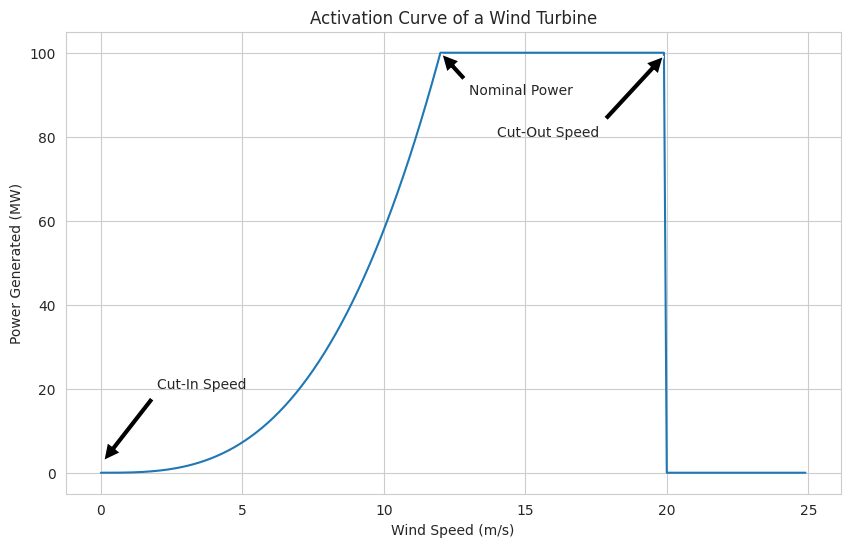

In [4]:
# Generate wind speed dat
wind_speed = np.arange(0, 25, 0.1)

# Define power values for each part of the curve
nominal_power = 100  # MW
nominal_speed = 12  # m/s
cut_out_speed = 20  # m/s

# Calculate power output for each wind speed
power_output = np.zeros_like(wind_speed)
for i, speed in enumerate(wind_speed):
    if speed < nominal_speed:
        power_output[i] = (speed / nominal_speed) ** 3 * nominal_power
    elif speed < cut_out_speed:
        power_output[i] = nominal_power
    else:
        power_output[i] = 0

# Plot the curve
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))
sns.lineplot(x=wind_speed, y=power_output)
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Power Generated (MW)')
plt.title('Activation Curve of a Wind Turbine')

# Annotate the plot with arrows and text
plt.annotate('Cut-In Speed', xy=(0, 2), xytext=(2, 20),
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate('Nominal Power', xy=(12, 100), xytext=(13, 90),
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate('Cut-Out Speed', xy=(20, 100), xytext=(14, 80),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.show()


## Date

The data was collected at various intervals, prompting me to introduce a DateTime column, anchored to the beginning of the testing period. Given that each interval spans 10 minutes, alongside a Month column for streamlined analysis.

In [5]:
df_WT1 = pd.read_csv('data/Inland Wind Farm Dataset1(WT1).csv')
df_WT2 = pd.read_csv('data/Inland Wind Farm Dataset1(WT2).csv')
df_WT3 = pd.read_csv('data/Inland Wind Farm Dataset1(WT3).csv')
df_WT4 = pd.read_csv('data/Inland Wind Farm Dataset1(WT4).csv')
df_WT5 = pd.read_csv('data/Offshore Wind Farm Dataset1(WT5).csv')
df_WT6 = pd.read_csv('data/Offshore Wind Farm Dataset1(WT6).csv')

In [6]:
# Set the start date and the time interval between samples (10 minutes)
start_date = pd.Timestamp('2010-07-30')
time_interval = pd.Timedelta(minutes=10)

# Create the datetime index
df_WT1['date_time'] = start_date + df_WT1.index * time_interval
df_WT2['date_time'] = start_date + df_WT2.index * time_interval

# Extract the months
df_WT1['month'] = df_WT1['date_time'].dt.month
df_WT2['month'] = df_WT2['date_time'].dt.month

In [7]:
# Set the start date and the time interval between samples (10 minutes)
start_date = pd.Timestamp('2010-04-30')
time_interval = pd.Timedelta(minutes=10)

# Create the datetime index
df_WT3['date_time'] = start_date + df_WT3.index * time_interval
df_WT4['date_time'] = start_date + df_WT4.index * time_interval

# Extract the months
df_WT3['month'] = df_WT3['date_time'].dt.month
df_WT4['month'] = df_WT4['date_time'].dt.month

In [8]:
# Set the start date and the time interval between samples (10 minutes)
start_date = pd.Timestamp('2009-01-01')
time_interval = pd.Timedelta(minutes=10)

# Create the datetime index
df_WT5['date_time'] = start_date + df_WT5.index * time_interval
df_WT6['date_time'] = start_date + df_WT6.index * time_interval

# Extract the months
df_WT5['month'] = df_WT5['date_time'].dt.month
df_WT6['month'] = df_WT6['date_time'].dt.month

In [9]:
windfarm_Onshore = pd.concat([df_WT3, df_WT4], ignore_index=True)
windfarm_Offshore = pd.concat([df_WT5, df_WT6], ignore_index=True)

In [10]:
windfarm_Onshore.duplicated().sum(), windfarm_Offshore.duplicated().sum()

(0, 0)

## Rename columns

In [11]:
windfarm_Onshore.columns

Index(['Sequence No.', 'V', 'D', 'air density', 'I', 'S_b',
       'y (% relative to rated power)', 'date_time', 'month'],
      dtype='object')

In [12]:
windfarm_Onshore.rename(columns = {'Sequence No.':'index',
                                   'V':'wind_speed', 
                                   'D':'wind_direction', 
                                   'air density': 'air_density', 
                                   'I':'turbulence_intensity', 
                                   'S_b':'wind_below_shear', 
                                   'y (% relative to rated power)':'rated_power'}, inplace = True)
windfarm_Onshore.drop(columns=['index'], inplace=True)
windfarm_Onshore.columns

Index(['wind_speed', 'wind_direction', 'air_density', 'turbulence_intensity',
       'wind_below_shear', 'rated_power', 'date_time', 'month'],
      dtype='object')

In [13]:
windfarm_Onshore.isnull().sum()

wind_speed              0
wind_direction          0
air_density             0
turbulence_intensity    0
wind_below_shear        0
rated_power             0
date_time               0
month                   0
dtype: int64

In [14]:
windfarm_Offshore.columns

Index(['Sequence No.', 'V', 'D', 'air density', 'humidity', 'I', 'S_a', 'S_b',
       'y (% relative to rated power)', 'date_time', 'month'],
      dtype='object')

In [15]:
windfarm_Offshore.rename(columns = {'Sequence No.':'index',
                                    'V':'wind_speed', 
                                    'D':'wind_direction', 
                                    'air density': 'air_density', 
                                    'I':'turbulence_intensity', 
                                    'S_a':'wind_above_shear',
                                    'S_b':'wind_below_shear', 
                                    'y (% relative to rated power)':'rated_power'}, inplace = True)
windfarm_Offshore.drop(columns=['index'], inplace=True)
windfarm_Offshore.columns

Index(['wind_speed', 'wind_direction', 'air_density', 'humidity',
       'turbulence_intensity', 'wind_above_shear', 'wind_below_shear',
       'rated_power', 'date_time', 'month'],
      dtype='object')

In [16]:

windfarm_Offshore.isnull().sum()

wind_speed              0
wind_direction          0
air_density             0
humidity                0
turbulence_intensity    0
wind_above_shear        0
wind_below_shear        0
rated_power             0
date_time               0
month                   0
dtype: int64

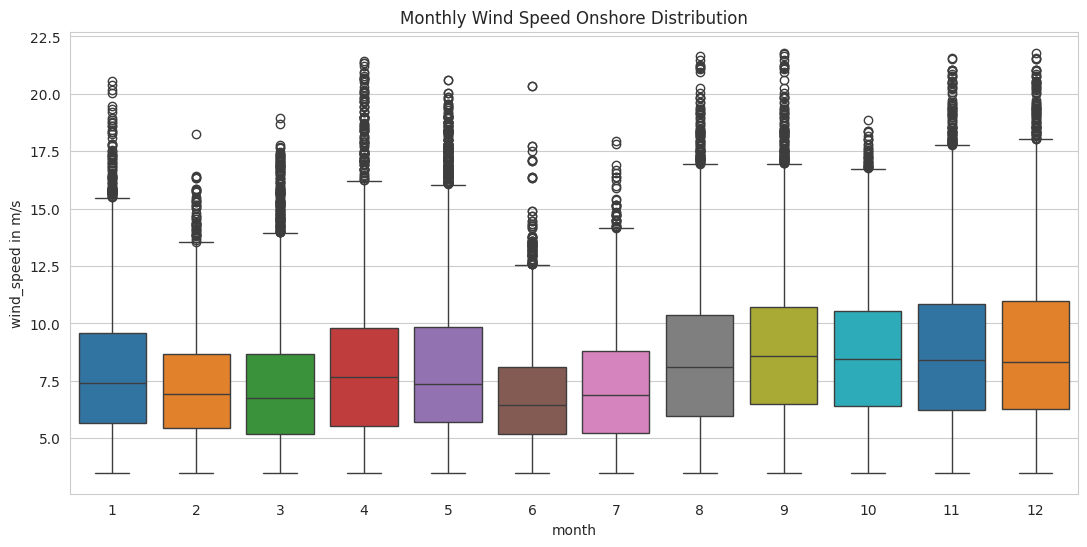

In [17]:
# Plotar o boxplot
plt.figure(figsize=(13, 6))
sns.boxplot(x="month", 
            y="wind_speed", 
            data=windfarm_Onshore, 
            hue="month", 
            palette="tab10", 
            legend=False)

plt.xlabel('month')
plt.ylabel('wind_speed in m/s')
plt.title('Monthly Wind Speed Onshore Distribution')

plt.savefig('assets/img/boxplot_wind_speed.png')#, transparent=True)

plt.show()

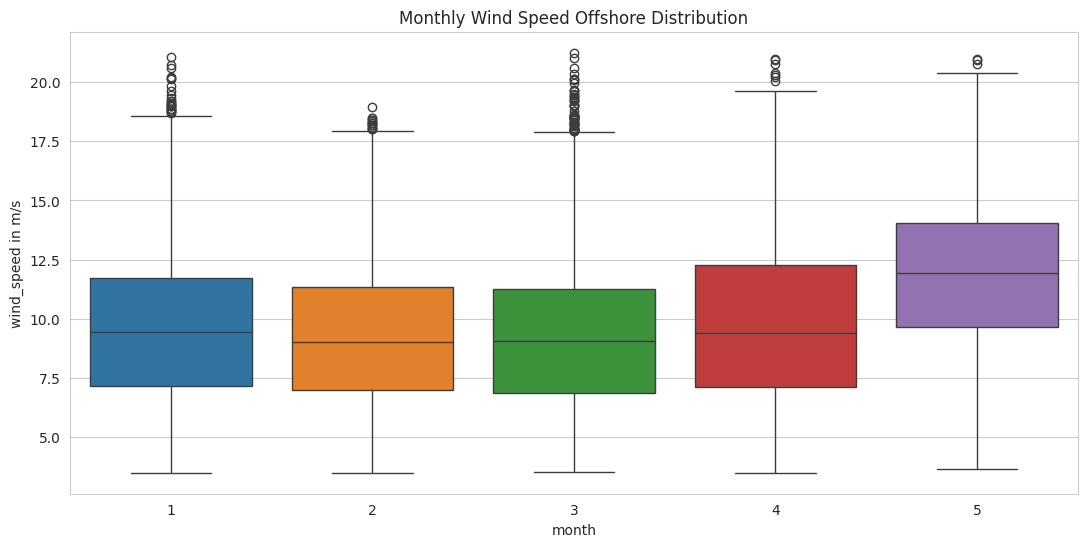

In [18]:
# Plotar o boxplot
plt.figure(figsize=(13, 6))
sns.boxplot(x="month", 
            y="wind_speed", 
            data=windfarm_Offshore, 
            hue="month", 
            palette="tab10", 
            legend=False)

plt.xlabel('month')
plt.ylabel('wind_speed in m/s')
plt.title('Monthly Wind Speed Offshore Distribution')
plt.show()

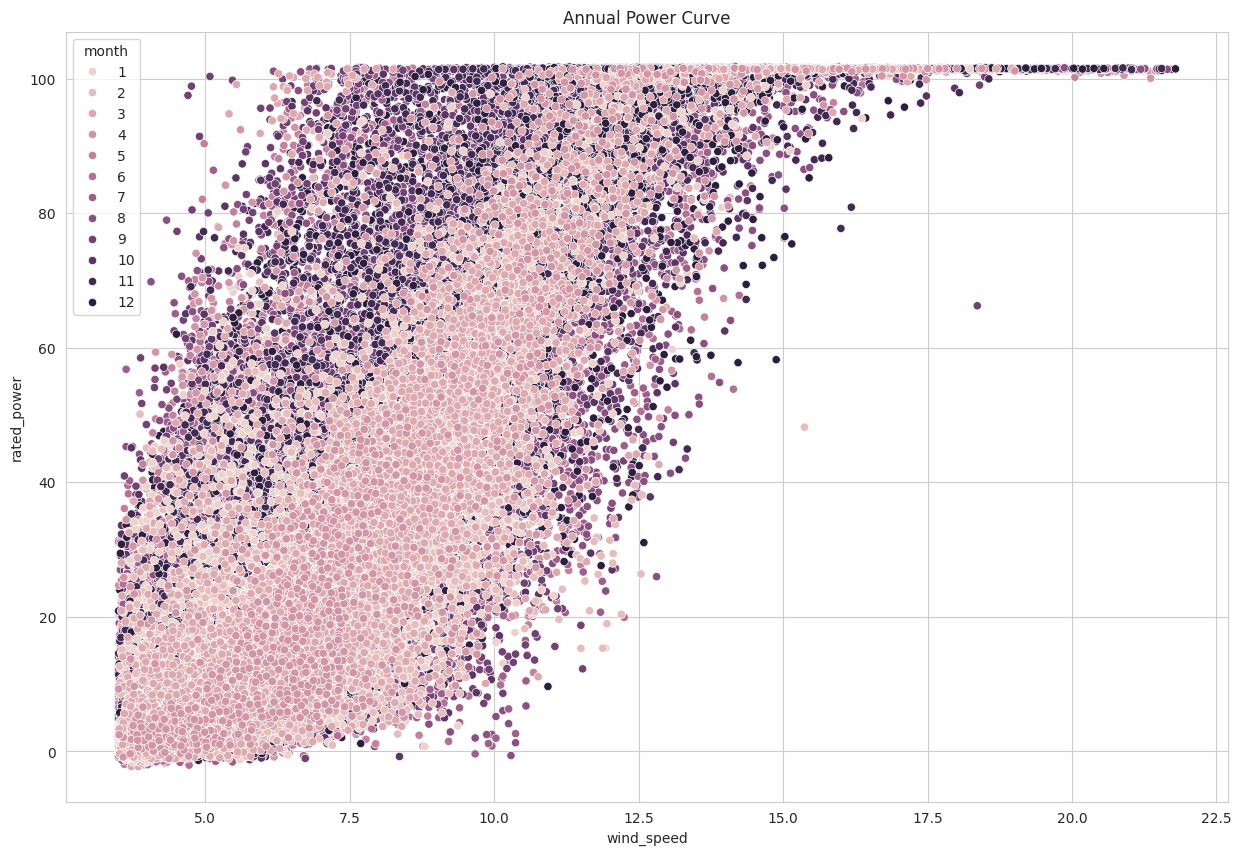

In [19]:
plt.figure(figsize = (15,10))
sns.scatterplot(x = windfarm_Onshore['wind_speed'], 
                y = windfarm_Onshore['rated_power'], 
                hue = windfarm_Onshore['month'], 
                legend="full")
plt.title("Annual Power Curve")
plt.savefig('assets/img/scatterplot_power.png')#, transparent=True)
plt.show()

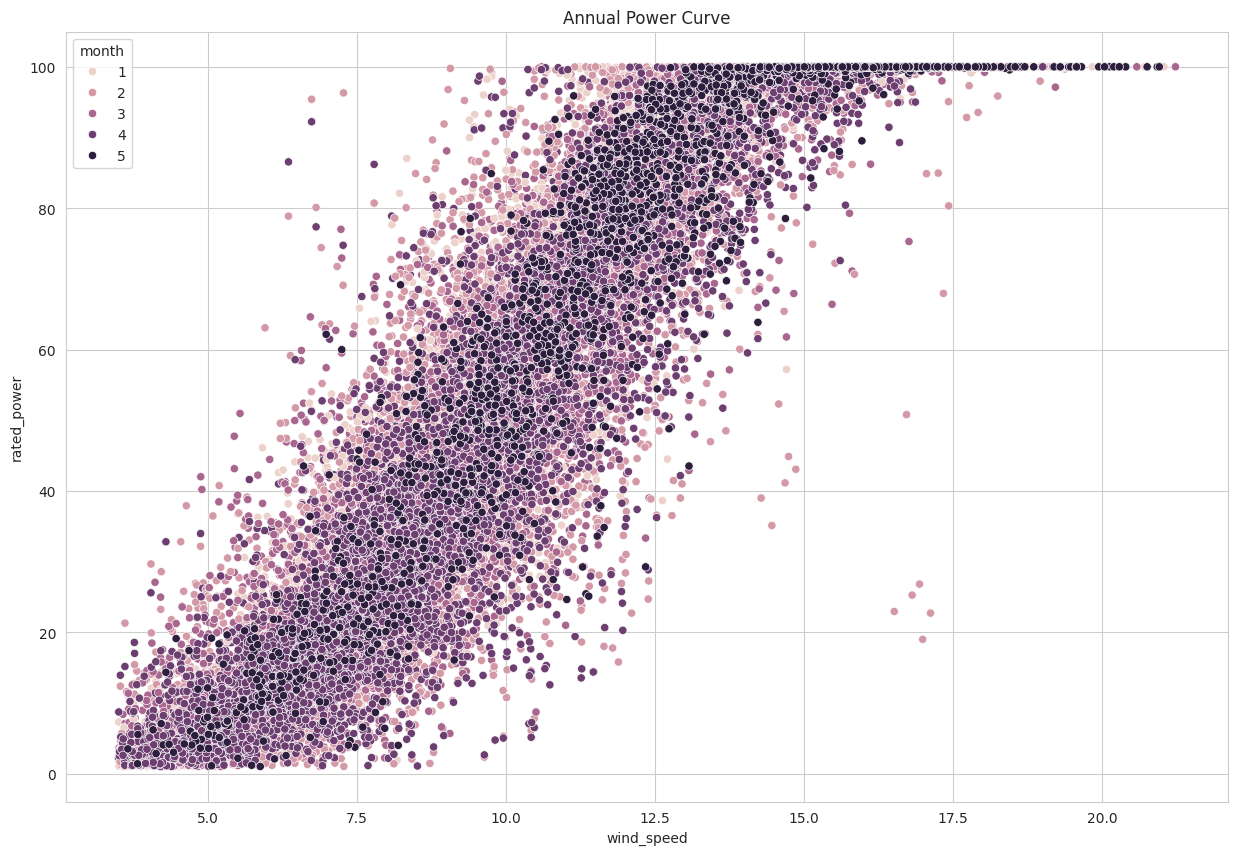

In [20]:
plt.figure(figsize = (15,10))
sns.scatterplot(x = windfarm_Offshore['wind_speed'], 
                y = windfarm_Offshore['rated_power'], 
                hue = windfarm_Offshore['month'], 
                legend="full")
plt.title("Annual Power Curve")
plt.show()

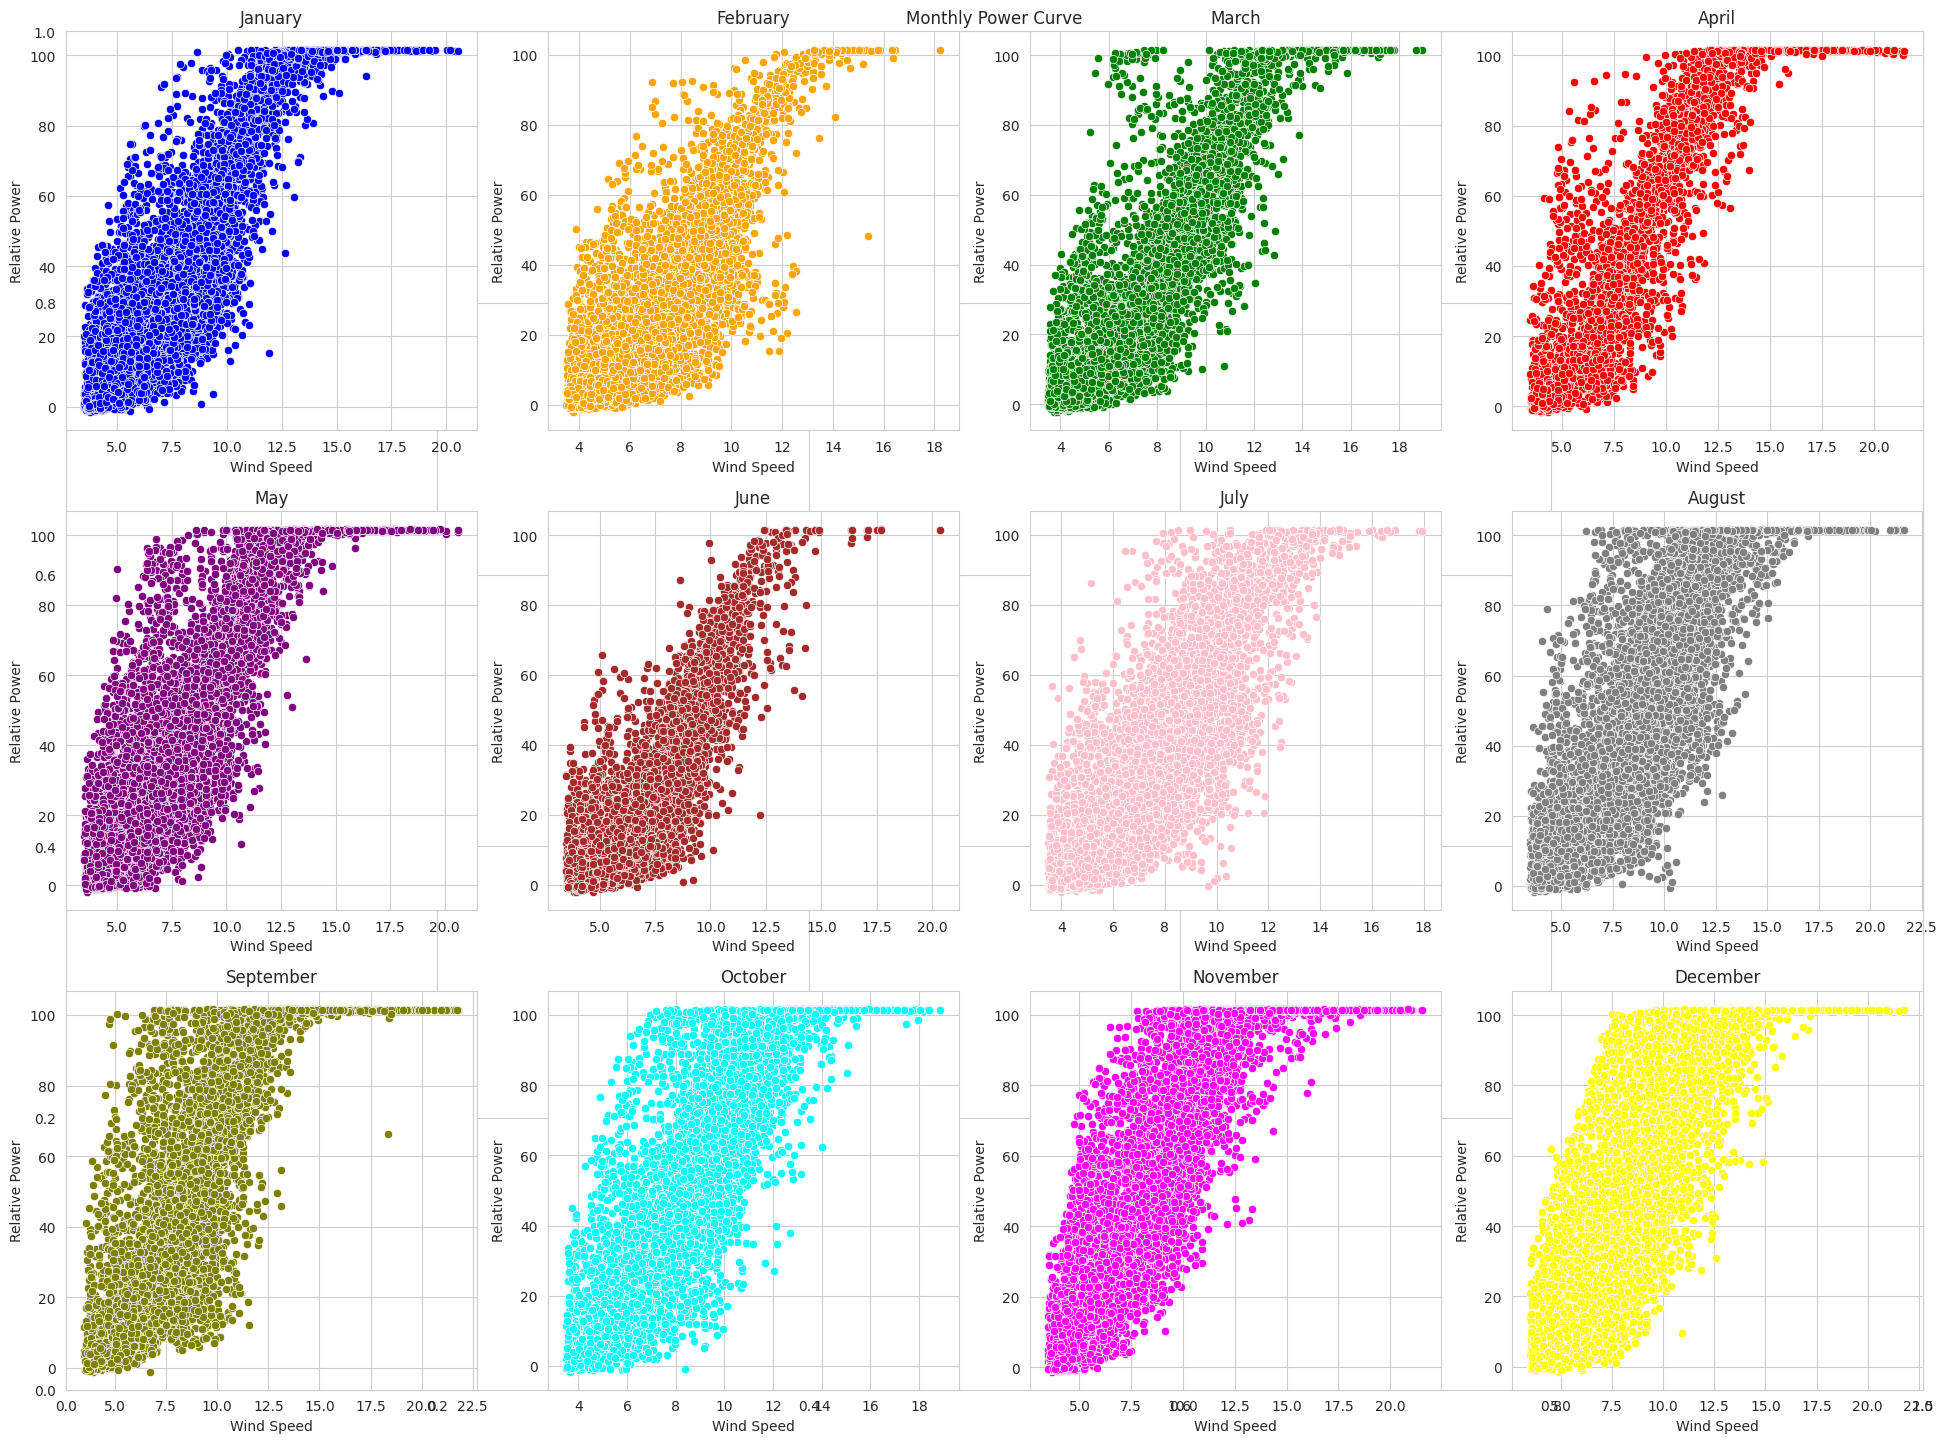

In [21]:
# Definindo um dicionário de cores para cada mês
colors = {1: 'blue', 2: 'orange', 3: 'green', 4: 'red', 5: 'purple', 6: 'brown', 
          7: 'pink', 8: 'gray', 9: 'olive', 10: 'cyan', 11: 'magenta', 12: 'yellow'}

plt.figure(figsize=(20, 15))
plt.title("Monthly Power Curve")
for i in range(1, 13):
    plt.subplot(3, 4, i)
    sns.scatterplot(x=windfarm_Onshore.wind_speed[windfarm_Onshore.month == i], 
                    y=windfarm_Onshore.rated_power[windfarm_Onshore.month == i], 
                    color=colors[i])
    plt.xlabel("Wind Speed")
    plt.ylabel("Relative Power")
    plt.title(calendar.month_name[i])

plt.tight_layout()
plt.savefig('assets/img/scatterplot_subplot_power.png')#, transparent=True)
plt.show()

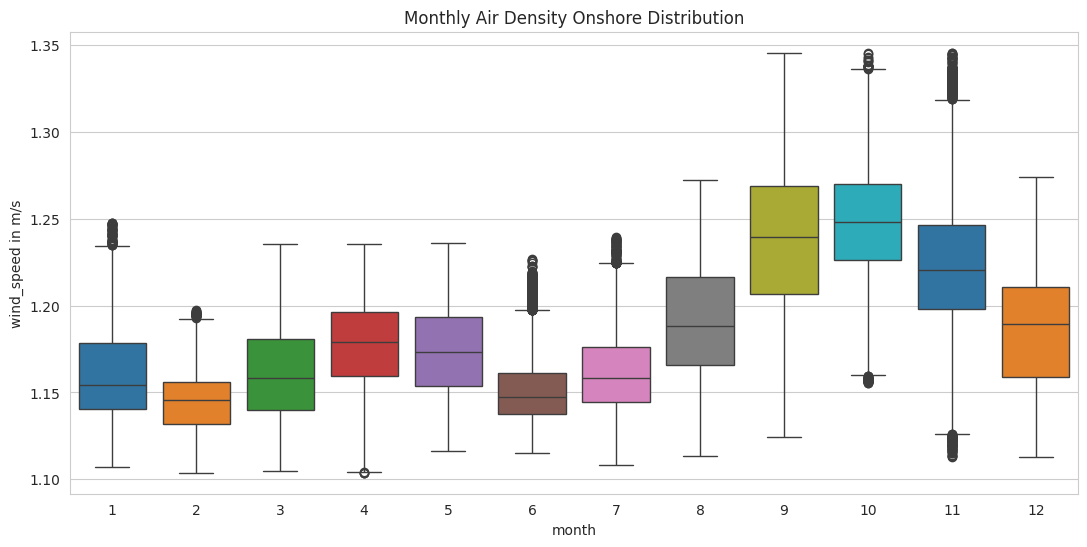

In [22]:
# Plotar o boxplot
plt.figure(figsize=(13, 6))
sns.boxplot(x="month", 
            y="air_density", 
            data=windfarm_Onshore, 
            hue="month", 
            palette="tab10", 
            legend=False)

plt.xlabel('month')
plt.ylabel('wind_speed in m/s')
plt.title('Monthly Air Density Onshore Distribution')
plt.savefig('assets/img/boxplot_air_density.png')#, transparent=True)
plt.show()

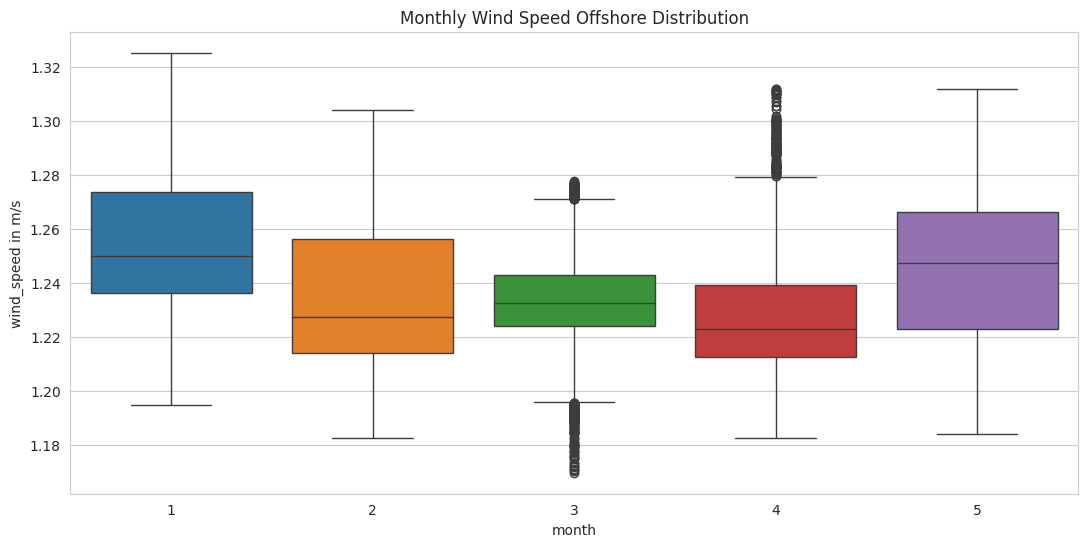

In [22]:
# Plotar o boxplot
plt.figure(figsize=(13, 6))
sns.boxplot(x="month", 
            y="air_density", 
            data=windfarm_Offshore, 
            hue="month", 
            palette="tab10", 
            legend=False)

plt.xlabel('month')
plt.ylabel('wind_speed in m/s')
plt.title('Monthly Wind Speed Offshore Distribution')
plt.show()

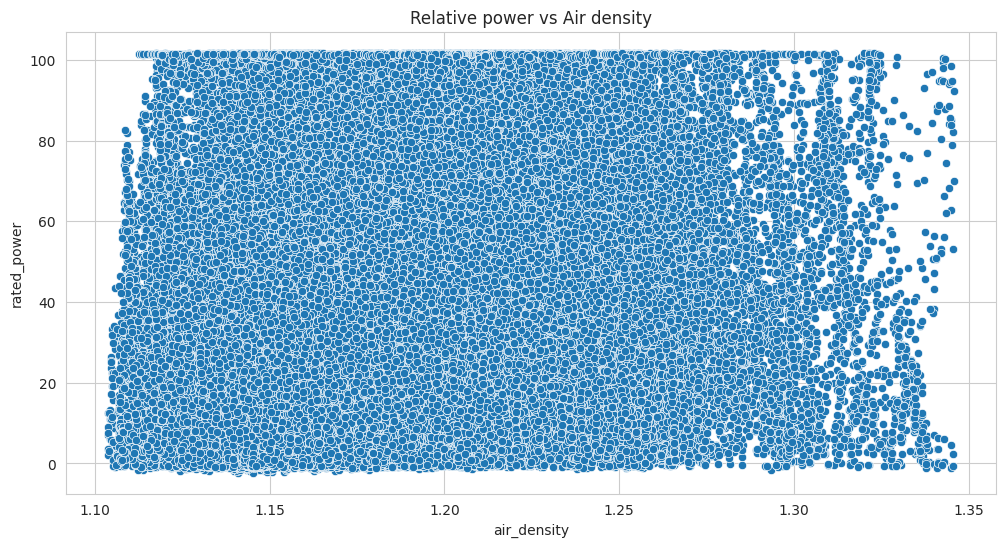

In [23]:
plt.figure(figsize = (12,6))
sns.scatterplot(x = windfarm_Onshore['air_density'], y = windfarm_Onshore['rated_power'])
plt.title("Relative power vs Air density");

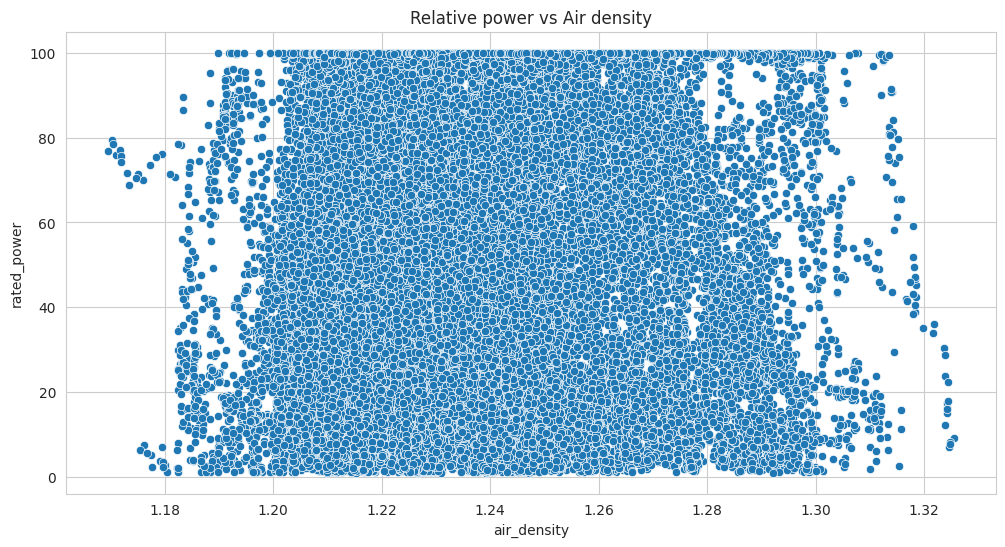

In [24]:
plt.figure(figsize = (12,6))
sns.scatterplot(x = windfarm_Offshore['air_density'], y = windfarm_Offshore['rated_power'])
plt.title("Relative power vs Air density");

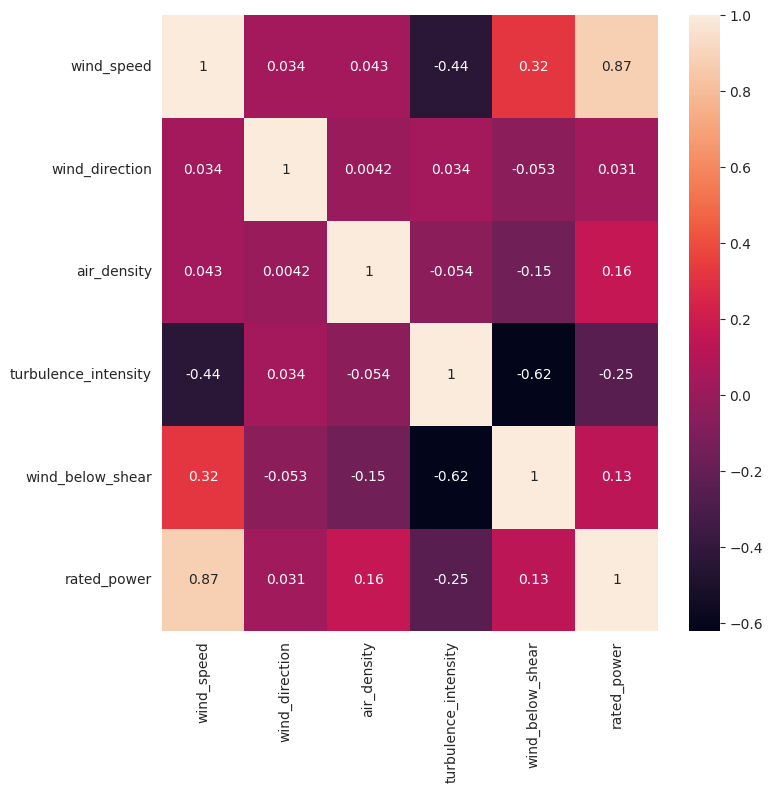

In [25]:
df_corr = windfarm_Onshore.drop(['date_time', 'month'], axis=1).corr()
plt.figure(figsize=(8,8))
sns.heatmap(df_corr, annot=True)
plt.yticks(rotation=0);
plt.savefig('assets/img/heatmap.png')#, transparent=True)
plt.show()

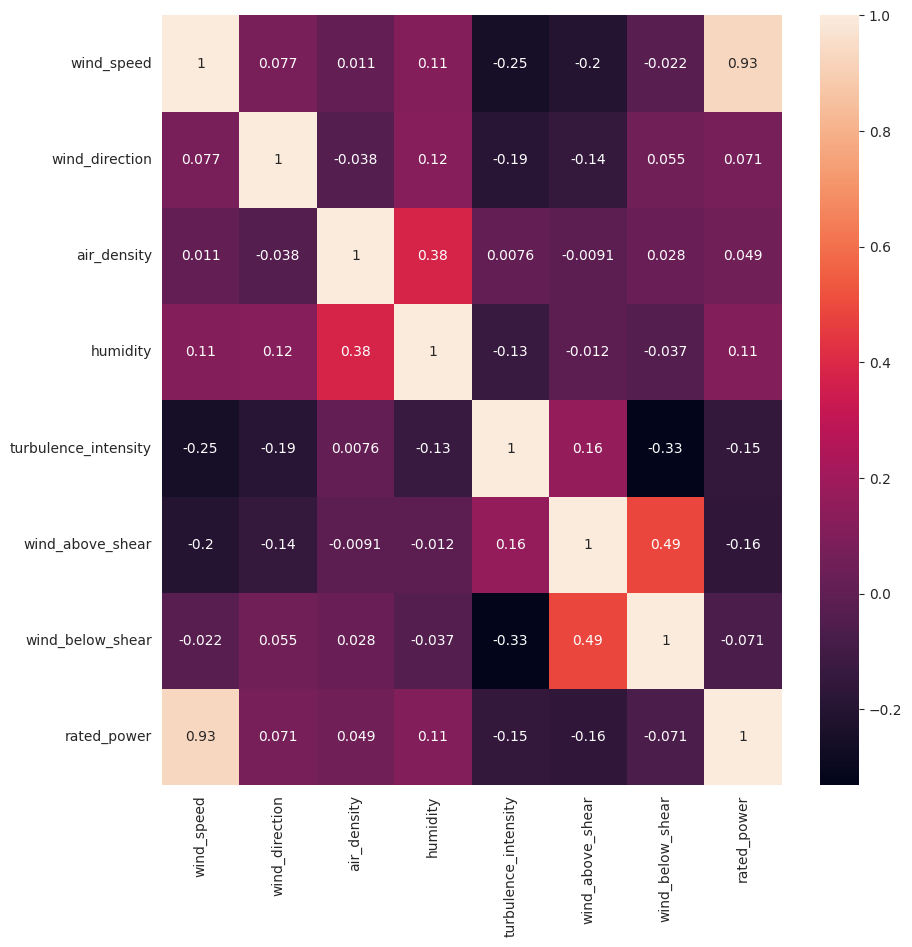

In [26]:
df_corr = windfarm_Offshore.drop(['date_time', 'month'], axis=1).corr()
plt.figure(figsize=(10,10))
sns.heatmap(df_corr, annot=True)
plt.yticks(rotation=0);
plt.show()

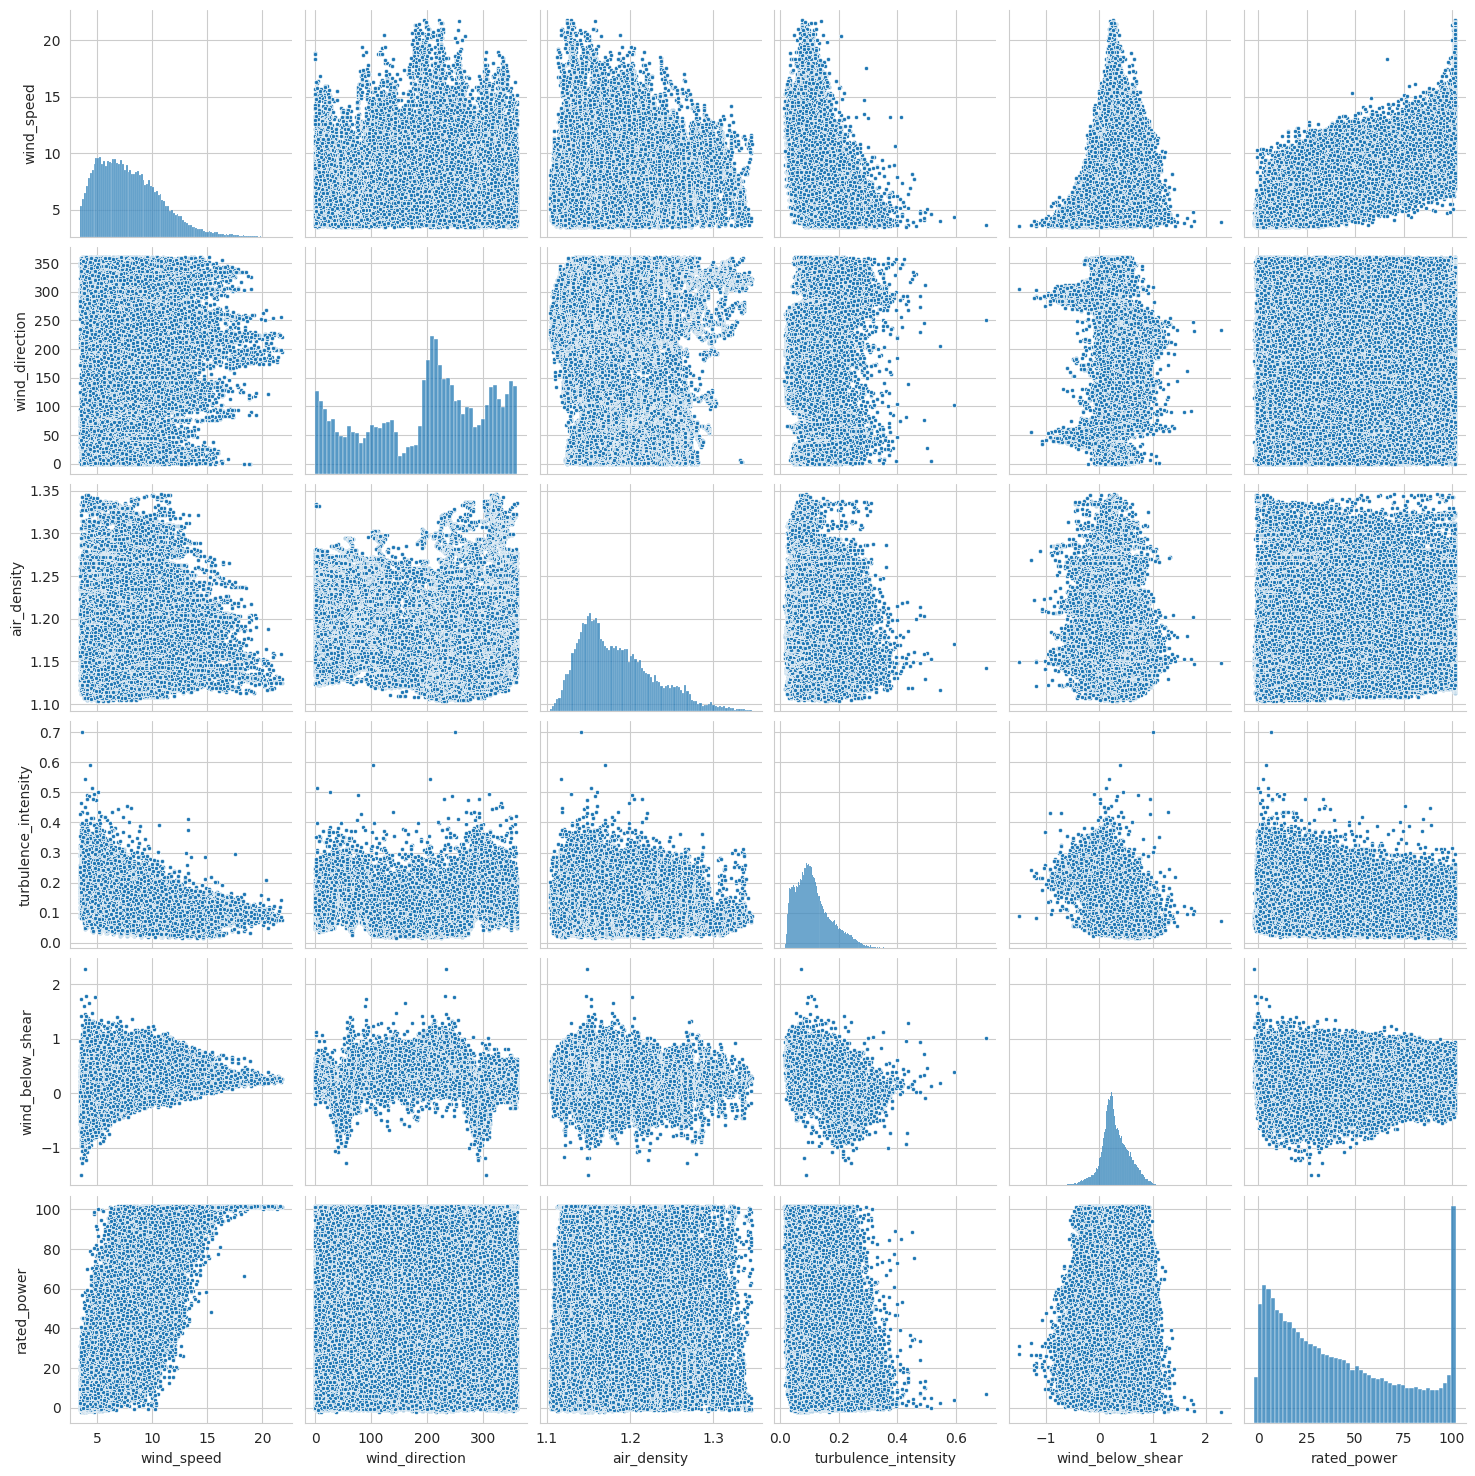

In [27]:
sns.pairplot(windfarm_Onshore.drop(['date_time', 'month'], axis=1), markers='.')

# Temporal series train


In [28]:
feats = ['wind_speed', 'wind_direction', 'air_density', 'turbulence_intensity', 'wind_below_shear', 'month']

# Temporal series validation
- Sliding-Window
- Expanding Window
- Censoring Between Past and Future

In [29]:
X = windfarm_Onshore[feats]
y = windfarm_Onshore['rated_power']

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X,y, 
                                                    # test_size=0.5, 
                                                    random_state=42)

In [31]:
def objective(trial):
    params = {'objective': 'reg:squarederror',
              'n_estimators': 5000,
              'seed' : 42,
              'verbosity' : 0,
              'learning_rate' : trial.suggest_float('learning_rate', 1e-3, 0.1, log=True),
              'max_depth' : trial.suggest_int('max_depth', 1, 10),
              'subsample' : trial.suggest_float('subsample', 0.05, 1.0),
              'colsample_bytree' : trial.suggest_float('colsample_bytree', 0.05, 1.0),
              'min_child_weight' : trial.suggest_int('min_child_weight', 1, 20)}

    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train, verbose=0)
    predictions = model.predict(X_test)
    rmse = root_mean_squared_error(y_test, predictions)
    return rmse

In [32]:
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=100)

# print(f"Best hyperparameters: {study.best_params}")
# print(f"Best RMSE: {study.best_value}")

In [33]:
best_params = {
    'learning_rate': 0.010965526038866571, 
    'max_depth': 9, 
    'subsample': 0.9293444263457029, 
    'colsample_bytree': 0.9016279029144538, 
    'min_child_weight': 10,
    'objective': 'reg:squarederror',              
    'n_estimators': 5000,
    'seed' : 42,
    'verbosity' : 0,
    'gamma' : 0,
    'reg_alpha' : 0, 
    'reg_lambda' : 0,
    }

# model = xgb.XGBRegressor(gamma=0, 
#                          learning_rate=0.01,
#                          max_depth=8,
#                          min_child_weight=3,
#                          n_estimators=1000,   
#                          reg_alpha=0,
#                          reg_lambda=0,
#                          subsample=0.8,
#                          objective='reg:squarederror',
#                          seed=42) 

In [34]:
model = xgb.XGBRegressor(**best_params)

## Normal Validadtion


In [35]:
model.fit(X_train, y_train)
predictions = model.predict(X_test)

r2_scores = (r2_score(y_test, predictions))
rmse_scores = root_mean_squared_error(y_test, predictions)
mae_scores = (mean_absolute_error(y_test, predictions))
mape_scores = (mean_absolute_percentage_error(y_test, predictions) * 100)
WMAPE = (mean_absolute_percentage_error(y_test, predictions, sample_weight=y_test) * 100)
male = (mean_squared_log_error(np.abs(y_test), np.abs(predictions)) * 100)

scores = {'R2 (%)': round(np.mean(r2_scores) * 100, 2),
          'RMSE': round(np.mean(rmse_scores), 2),
          'MAE': round(np.mean(mae_scores), 2),
          'WMAPE' : round(np.mean(WMAPE), 2),
          'male (%)' : round(np.mean(male), 2),
          'MAPE': round(np.mean(mape_scores), 2)}
scores_list = [scores]

normal_temporal = pd.DataFrame(scores_list)
normal_temporal

R2 (%)  RMSE  MAE  WMAPE  male (%)          MAPE
0   93.72  7.96  5.5  13.17      13.5  1.450405e+14

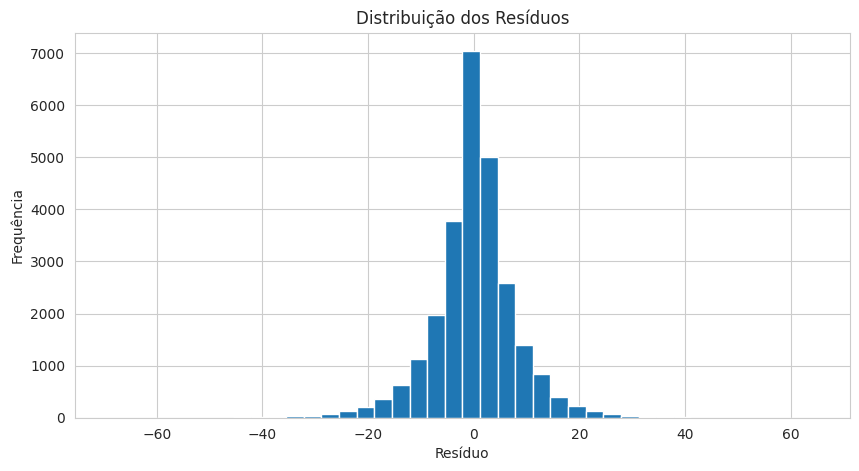

In [36]:
residuos = y_test - predictions

plt.figure(figsize=(10, 5))
plt.hist(residuos, bins=40)
plt.xlabel('Resíduo')
plt.ylabel('Frequência')
plt.title('Distribuição dos Resíduos')
plt.show()

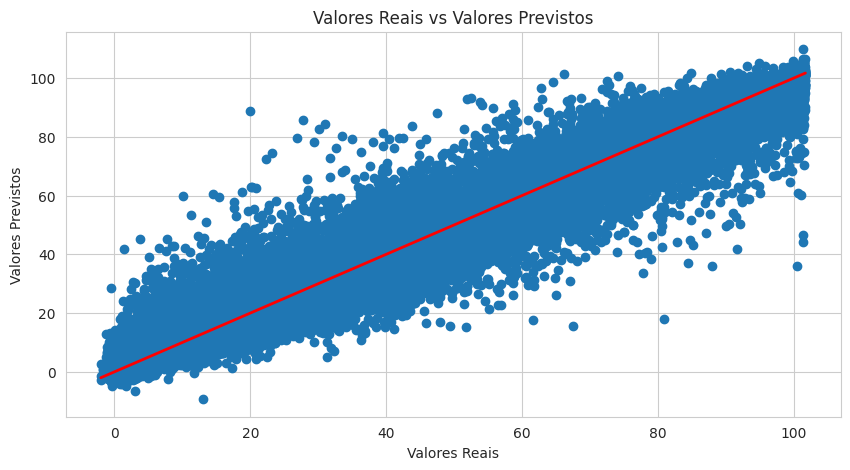

In [37]:
plt.figure(figsize=(10, 5))
plt.scatter(y_test, predictions)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linewidth=2)
plt.xlabel('Valores Reais')
plt.ylabel('Valores Previstos')
plt.title('Valores Reais vs Valores Previstos')
plt.show()

## Cross Validation

In [38]:
cv = KFold(n_splits=5, random_state=42, shuffle=True)

r2_scores_cross_validation = []
rmse_scores_cross_validation = []
mae_scores_cross_validation = []
mape_scores_cross_validation = []
WMAPE_cross_validation = []
male_cross_validation = []

for index_split, (index_train, index_validation) in enumerate(cv.split(X, y)):
    X_train, X_validation = X.iloc[index_train, :], X.iloc[index_validation, :]
    y_train, y_validation = y.iloc[index_train], y.iloc[index_validation]
    
    # Se for necessário oversampling, descomente as linhas abaixo
    # if oversampling:
    #     smote = SMOTE(random_state=42)
    #     X_train, y_train = smote.fit_resample(X_train, y_train)

    model.fit(X_train, y_train.values.flatten())
    predictions = model.predict(X_validation)
    
    r2_scores_cross_validation.append(r2_score(y_validation, predictions))
    rmse_scores_cross_validation.append(root_mean_squared_error(y_validation, predictions))
    mae_scores_cross_validation.append(mean_absolute_error(y_validation, predictions))
    mape_scores_cross_validation.append(mean_absolute_percentage_error(y_validation, predictions) * 100)
    WMAPE_cross_validation.append(mean_absolute_percentage_error(y_validation, predictions, sample_weight=y_validation) * 100)
    male_cross_validation.append(mean_squared_log_error(np.abs(y_validation), np.abs(predictions)) * 100)
    
    


scores = {'R2 (%)': round(np.mean(r2_scores) * 100, 2),
          'RMSE': round(np.mean(rmse_scores), 2),
          'MAE': round(np.mean(mae_scores), 2),
          'WMAPE' : round(np.mean(WMAPE), 2),
          'male (%)' : round(np.mean(male), 2),
          'MAPE': round(np.mean(mape_scores), 2)}
scores_list = [scores]

cross_validation = pd.DataFrame(scores_list)
cross_validation
# accuracy_without_oversampling, second_level, cv = cross_validation(algorithms, X_train, y_train, n_splits, seed_number)
# accuracy_without_oversampling

R2 (%)  RMSE  MAE  WMAPE  male (%)          MAPE
0   93.72  7.96  5.5  13.17      13.5  1.450405e+14

## Simple Temporal Validation

In [51]:
test_months = list(range(1, 6))

X_train, X_test = X[~windfarm_Onshore['month'].isin(test_months)], X[windfarm_Onshore['month'].isin(test_months)]
y_train, y_test = y[~windfarm_Onshore['month'].isin(test_months)], y[windfarm_Onshore['month'].isin(test_months)]

model.fit(X_train, y_train)
predictions = model.predict(X_test)

r2_scores = (r2_score(y_test, predictions))
rmse_scores = root_mean_squared_error(y_test, predictions)
mae_scores = (mean_absolute_error(y_test, predictions))
mape_scores = (mean_absolute_percentage_error(y_test, predictions) * 100)
WMAPE = (mean_absolute_percentage_error(y_test, predictions, sample_weight=y_test) * 100)
male = (mean_squared_log_error(np.abs(y_test), np.abs(predictions)) * 100)

scores = {'R2 (%)': round(np.mean(r2_scores) * 100, 2),
          'RMSE': round(np.mean(rmse_scores), 2),
          'MAE': round(np.mean(mae_scores), 2),
          'WMAPE' : round(np.mean(WMAPE), 2),
          'male (%)' : round(np.mean(male), 2),
          'MAPE': round(np.mean(mape_scores), 2)}
scores_list = [scores]

simple_temporal = pd.DataFrame(scores_list)
simple_temporal

R2 (%)   RMSE   MAE  WMAPE  male (%)          MAPE
0   86.16  10.99  8.05  21.85     21.97  2.838327e+14

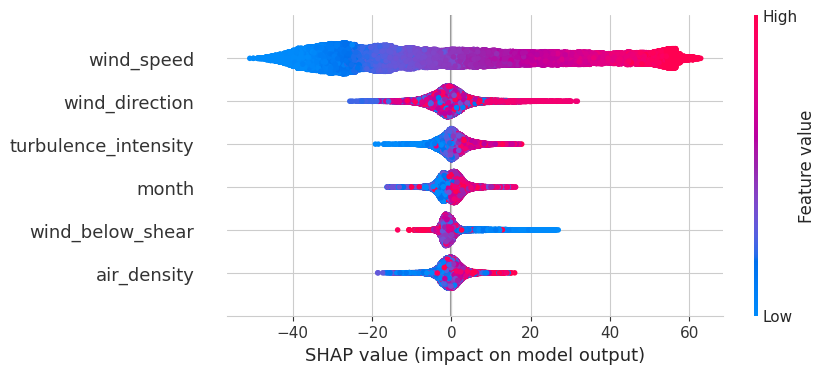

In [40]:
import shap

explainer = shap.Explainer(model)
shap_values = explainer(X_train)

shap.plots.beeswarm(shap_values)

## Temporal Validation With Sliding Window

In [41]:
r2_scores = []
rmse_scores = []
mae_scores = []
mape_scores = []
WMAPE = []
male = []
for month in windfarm_Onshore['month'].unique():
    if month > 1:
        delta = month - 1
        if delta == 0:
            delta = 12
        X_train, X_test = X[windfarm_Onshore['month'] == delta], X[windfarm_Onshore['month'] == month]
        y_train, y_test = y[windfarm_Onshore['month'] == delta], y[windfarm_Onshore['month'] == month]
        
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        
        r2_scores.append(r2_score(y_test, predictions))
        rmse_scores.append(root_mean_squared_error(y_test, predictions))
        mae_scores.append(mean_absolute_error(y_test, predictions))
        mape_scores.append(mean_absolute_percentage_error(y_test, predictions) * 100)
        WMAPE.append(mean_absolute_percentage_error(y_test, predictions, sample_weight=y_test) * 100)
        male.append(mean_squared_log_error(np.abs(y_test), np.abs(predictions)) * 100)

scores = {'R2 (%)': round(np.mean(r2_scores) * 100, 2),
          'RMSE': round(np.mean(rmse_scores), 2),
          'MAE': round(np.mean(mae_scores), 2),
          'WMAPE' : round(np.mean(WMAPE), 2),
          'male (%)' : round(np.mean(male), 2),
          'MAPE': round(np.mean(mape_scores), 2)}
scores_list = [scores]

sliding_window = pd.DataFrame(scores_list)
sliding_window

R2 (%)   RMSE   MAE  WMAPE  male (%)          MAPE
0   80.18  13.02  9.29  23.22     26.77  2.117786e+14

## Temporal Validation With Expansive Window

In [42]:
r2_scores = []
rmse_scores = []
mae_scores = []
mape_scores = []
WMAPE = []
male = []
for month in windfarm_Onshore['month'].unique():
    if month > 1:
        if delta == 0:
            delta = 12
        X_train, X_test = X[windfarm_Onshore['month'] < month], X[windfarm_Onshore['month'] == month]
        y_train, y_test = y[windfarm_Onshore['month'] < month], y[windfarm_Onshore['month'] == month]
        
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        
        r2_scores.append(r2_score(y_test, predictions))
        rmse_scores.append(root_mean_squared_error(y_test, predictions))
        mae_scores.append(mean_absolute_error(y_test, predictions))
        mape_scores.append(mean_absolute_percentage_error(y_test, predictions) * 100)
        WMAPE.append(mean_absolute_percentage_error(y_test, predictions, sample_weight=y_test) * 100)
        male.append(mean_squared_log_error(np.abs(y_test), np.abs(predictions)) * 100)

scores = {'R2 (%)': round(np.mean(r2_scores) * 100, 2),
          'RMSE': round(np.mean(rmse_scores), 2),
          'MAE': round(np.mean(mae_scores), 2),
          'WMAPE' : round(np.mean(WMAPE), 2),
          'male (%)' : round(np.mean(male), 2),
          'MAPE': round(np.mean(mape_scores), 2)}
scores_list = [scores]

expansive_window = pd.DataFrame(scores_list)
expansive_window

R2 (%)   RMSE   MAE  WMAPE  male (%)          MAPE
0   81.93  12.41  8.76  21.94     24.16  1.445954e+14

## Temporal Validation With Censorship Between Past and Future

In [43]:
r2_scores = []
rmse_scores = []
mae_scores = []
mape_scores = []
WMAPE = []
male = []

for month in windfarm_Onshore['month'].unique():
    if month > 2:
        delta = month - 2
        if delta == 0:
            delta = 12
        X_train, X_test = X[windfarm_Onshore['month'] == delta], X[windfarm_Onshore['month'] == month]
        y_train, y_test = y[windfarm_Onshore['month'] == delta], y[windfarm_Onshore['month'] == month]
        
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        
        r2_scores.append(r2_score(y_test, predictions))
        rmse_scores.append(root_mean_squared_error(y_test, predictions))
        mae_scores.append(mean_absolute_error(y_test, predictions))
        mape_scores.append(mean_absolute_percentage_error(y_test, predictions) * 100)
        WMAPE.append(mean_absolute_percentage_error(y_test, predictions, sample_weight=y_test) * 100)
        male.append(mean_squared_log_error(np.abs(y_test), np.abs(predictions)) * 100)

scores = {'R2 (%)': round(np.mean(r2_scores) * 100, 2),
          'RMSE': round(np.mean(rmse_scores), 2),
          'MAE': round(np.mean(mae_scores), 2),
          'WMAPE' : round(np.mean(WMAPE), 2),
          'male (%)' : round(np.mean(male), 2),
          'MAPE': round(np.mean(mape_scores), 2)}
scores_list = [scores]

censorship = pd.DataFrame(scores_list)
censorship

R2 (%)   RMSE   MAE  WMAPE  male (%)          MAPE
0   79.95  13.46  9.75  23.21     26.82  2.801625e+14

---

In [52]:
combined_df = pd.concat([censorship, 
                         expansive_window, 
                         sliding_window, 
                         simple_temporal, 
                         cross_validation,
                         normal_temporal], ignore_index=True)
index_names = ['censorship', 
               'expansive_window', 
               'sliding_window', 
               'simple_temporal', 
               'cross_validation',
               'normal_temporal']


combined_df['index_name'] = index_names
combined_df = combined_df.set_index('index_name')

combined_df.sort_values(by='RMSE')

R2 (%)   RMSE   MAE  WMAPE  male (%)          MAPE
index_name                                                          
cross_validation   93.72   7.96  5.50  13.17     13.50  1.450405e+14
normal_temporal    93.72   7.96  5.50  13.17     13.50  1.450405e+14
simple_temporal    86.16  10.99  8.05  21.85     21.97  2.838327e+14
expansive_window   81.93  12.41  8.76  21.94     24.16  1.445954e+14
sliding_window     80.18  13.02  9.29  23.22     26.77  2.117786e+14
censorship         79.95  13.46  9.75  23.21     26.82  2.801625e+14